In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import ariel_load
import tqdm
importlib.reload(kgs);

local
local


In [2]:
%%time
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)
data = train_data[0]

CPU times: user 410 ms, sys: 164 ms, total: 574 ms
Wall time: 1.72 s


In [3]:
def robust_linear_fit_rms(X, Y, drop_frac=0.05):
    X = np.asarray(X)
    Y = np.asarray(Y)

    # Fit Y = aX + b using least squares
    A = np.vstack([X, np.ones_like(X)]).T
    a, b = np.linalg.lstsq(A, Y, rcond=None)[0]

    # Predicted Y and residuals
    Y_pred = a * X + b
    residuals = Y - Y_pred
    abs_resid = np.abs(residuals)

    # Remove worst 5% (highest absolute residuals)
    if drop_frac>0:
        n = len(residuals)
        keep = int(n * (1 - drop_frac))
        indices = np.argpartition(abs_resid, keep)[:keep]
    #print(keep, len(residuals))
    else:
        indices = np.arange(len(residuals))

    # Compute RMS of the remaining residuals
    rms = np.sqrt(np.mean(residuals[indices] ** 2))
    print(a,b)
    return rms

In [4]:
import ariel_simple
importlib.reload(ariel_simple)
df = 0.05
for jj in [0]:
    model = ariel_simple.SimpleModel()
    model.run_in_parallel = False
    match jj:
        case 0:
            name = 'Default'
        case 1:
            name = 'Use correction factor'
            model.use_correction_factor = True        
    model.do_plots = False
    model.train(train_data)
    data = train_data
    inferred_data = model.infer(data)
    print(name)
    solution = kgs.make_submission_dataframe(data, include_sigma=False)
    submission = kgs.make_submission_dataframe(inferred_data, False)
    print(1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=df), 1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=0))
    print(1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=df),
         1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=0))
    kgs.dill_save(kgs.temp_dir + '/test_simple.pickle', inferred_data)

Inferring: 100%|████████████████████████████████████████████████████████████████████| 1100/1100 [56:58<00:00,  3.11s/it]


Default
-0.00024098025152486014 5.297339113405722e-06
-0.00024098025152486014 5.297339113405722e-06
182.20617986481048 313.08081862345705
0.0001914213195778493 1.5578168413798222e-06
0.0001914213195778493 1.5578168413798222e-06
79.95635090217013 210.60501413177823


In [5]:
print(1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=df), 1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=0))
print(1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=df),
    1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=0))

-0.00024098025152486014 5.297339113405722e-06
-0.00024098025152486014 5.297339113405722e-06
182.20617986481048 313.08081862345705
0.0001914213195778493 1.5578168413798222e-06
0.0001914213195778493 1.5578168413798222e-06
79.95635090217013 210.60501413177823


In [6]:
score, rms_err = kgs.score_metric(inferred_data, data)
#np.sqrt(np.diag(inferred_data[0].spectrum_cov))

Score:     0.4105
RMS error: 502.2590 ppm


In [7]:
import copy
data_sim = copy.deepcopy(data)
sig = rms_err
for ii,d in enumerate(data_sim):
    d.spectrum += np.random.default_rng(seed=ii).normal(0,sig,size=d.spectrum.shape)
    d.spectrum_cov = np.diag(0*d.spectrum+sig**2)
    d.check_constraints()
print('Theoretical')
kgs.score_metric(data_sim, data);

Theoretical
Score:     0.3823
RMS error: 501.8123 ppm


In [8]:
kgs.print_sanity_checks()

gain [0.4369, 0.4369] [0.4, 0.5] 1
offset [-1000.0, -1000.0] [-1001, -999] 2
ratio_hot [0.0, 0.0107421875] [0, 0.018] 3
ratio_dead [0.0013297872340425532, 0.0029296875] [0, 0.012] 4
linear_corr_impact [3689.96146487254, 30443.11870272854] [0, 50000] 9
dark_min [-0.0007936957993979564, 0.002066195137730647] [-0.01, 0.01] 5
dark_max [0.01163899428117778, 0.013298721036968861] [0.005, 0.02] 6
flat_min [0.8617695468230018, 0.9478742031905644] [0.5, 1.05] 7
flat_max [1.0383349568133693, 1.0837272656512849] [0.95, 1.2] 8
cosmic_ray_removal [0.0, 1.1623325453112688e-06] [0, 5e-06] 10
simple_t0 [10800.785166397125, 16197.737447952435] [9000.0, 18000] 11
simple_residual_ratio_FGS [0.9595878306010153, 1.1191341658234728] [0.9, 2.0] 12
simple_residual_ratio_AIRS [0.968033933527895, 1.752244480408357] [0.9, 2.0] 13


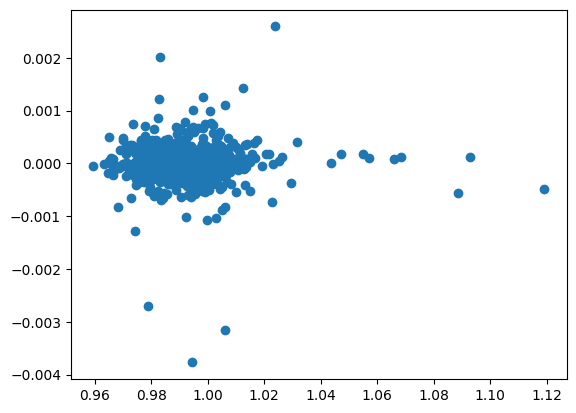

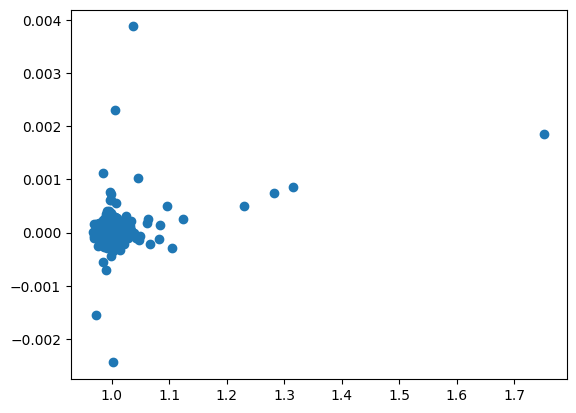

In [17]:
plt.figure();
plt.scatter(kgs.sanity_checks['simple_residual_ratio_FGS'].seen_all, solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy())
plt.figure();
plt.scatter(kgs.sanity_checks['simple_residual_ratio_AIRS'].seen_all, np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1))

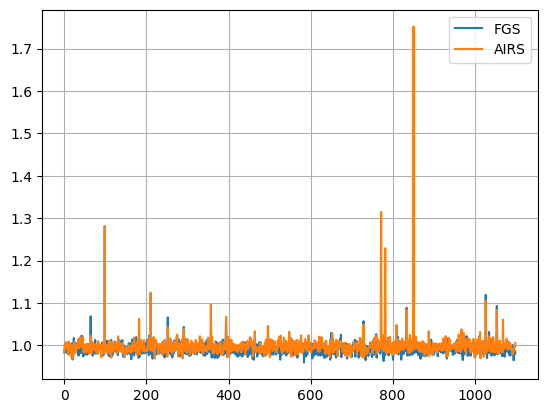

In [9]:
plt.figure()
plt.plot(kgs.sanity_checks['simple_residual_ratio_FGS'].seen_all)
plt.plot(kgs.sanity_checks['simple_residual_ratio_AIRS'].seen_all)
plt.legend(('FGS', 'AIRS'))
plt.grid(True)

In [10]:
solution = kgs.make_submission_dataframe(data, include_sigma=False)
submission = kgs.make_submission_dataframe(inferred_data, False)


In [11]:
kgs.rms(solution.iloc[:,1:2].to_numpy()-submission.iloc[:,1:2].to_numpy()),kgs.rms(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy())

(0.0003130963725749593, 0.0005028031357932226)

Text(0.5, 1.0, '502.8031357932226')

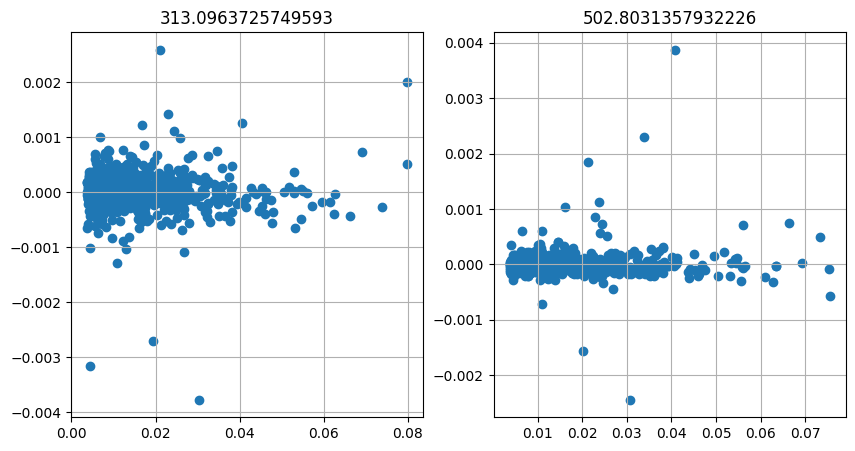

In [12]:
_,ax=plt.subplots(1,2,figsize=(10,5))
plt.sca(ax[0])
plt.box(True);plt.grid(True);
plt.scatter(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy())
plt.title(1e6*kgs.rms(solution.iloc[:,1:2].to_numpy()-submission.iloc[:,1:2].to_numpy()))
plt.sca(ax[1])
plt.box(True);plt.grid(True);
plt.scatter(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1))
plt.title(1e6*kgs.rms(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy()))

In [13]:
ind = np.argmax(np.abs(np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1)))
ind

968

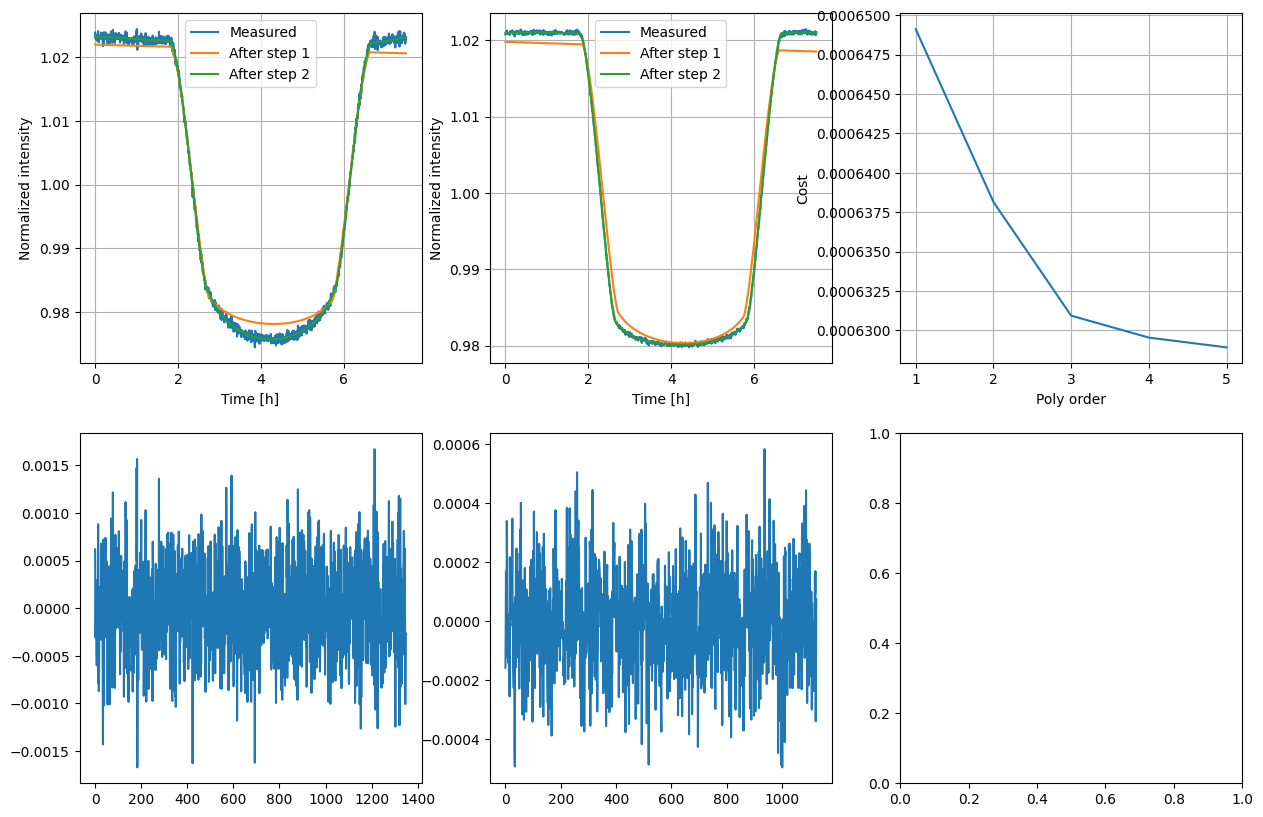

[1.1576735485299767, 1.1343814632411002]
0.0008749024930100255 0.0037660491029036626 0.00016395281231290488


In [14]:
import ariel_simple
import copy
kgs.sanity_checks_active = False
importlib.reload(ariel_simple)
ind=968
model = ariel_simple.SimpleModel()
model.run_in_parallel = False
model.do_plots = True
model.use_correction_factor = True
model.train(train_data)
data = copy.deepcopy(train_data[ind:ind+1])
#kgs.list_attrs(data[0])
# for d_ref in train_data:
#     dat = copy.deepcopy(d_ref)
#     dat.spectrum = train_data[ind].spectrum
#     dat.planet_id = train_data[ind].planet_id
#     data = [dat]
    #data[0].sma = sma
    #for ii in range(2):
    #    pass
       #model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_pixels = False    
       #model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_rows = False    
     #   model.loaders[ii].apply_pixel_corrections.mask_hot = False
     #   model.loaders[ii].apply_pixel_corrections.mask_hot = False
inferred_data = model.infer(data)
print(model.correction_factor)
print(np.mean(data[0].spectrum[:1]-inferred_data[0].spectrum[:1]), np.mean(data[0].spectrum[1:]-inferred_data[0].spectrum[1:]), kgs.rms(model.pred[1]-model._targets[1]))